In [40]:
import ast
import time
import pickle
import warnings
import numpy as np
import pandas as pd
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tqdm import tqdm

from datetime import timedelta 
from data import load_dataset
from loguru import logger as log
from val import calculate_metrics
#
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
plt.style.use('seaborn-whitegrid')
pd.set_option('display.float_format', '{:.16f}'.format)

## Load data

In [4]:
train_dataset = load_dataset('../../data/graph_designer/train_test/dataset_train.pkl')
test_dataset = load_dataset('../../data/graph_designer/train_test/dataset_test.pkl')
df_nodes = pd.read_csv('../../data/graph_designer/train_test/df_nodes_selected.csv')
nodes = list(df_nodes.tensor_idx.values)
df_nodes_loader = pd.read_csv('../../data/graph_designer/train_test/df_nodes_selected_loader.csv')
df_nodes_loader['time'] = pd.to_datetime(df_nodes_loader['time'], format='%Y-%m-%d %H:%M:%S')

In [5]:
# data train and test
df_train = df_nodes_loader.query(" partition == 'train' ").copy()
df_test  = df_nodes_loader.query(" partition != 'train' ").copy()

In [6]:
df_test.head()

,time,day,partition,partition_nn,carregamento_node_694,carregamento_node_2772,carregamento_node_1203,carregamento_node_592,carregamento_node_561
1668,2024-03-08 00:00:00,8,test,test,26.6666666666666679,24.5833333333333286,0.2500000000000000,2.5000000000000000,17.5833333333333321
1669,2024-03-08 00:05:00,8,test,test,24.4166666666666679,24.8333333333333286,0.5000000000000000,2.5000000000000000,11.4166666666666661
1670,2024-03-08 00:10:00,8,test,test,18.0000000000000000,18.0000000000000000,0.5000000000000000,1.5000000000000000,11.1666666666666661
1671,2024-03-08 00:15:00,8,test,test,18.2500000000000000,12.9166666666666661,0.5000000000000000,1.5000000000000000,9.3333333333333339
1672,2024-03-08 00:20:00,8,test,test,15.4166666666666661,8.6666666666666661,0.5000000000000000,1.5000000000000000,9.2500000000000000


In [8]:
def forecasting_sarima(fpath_model, node, ts_train):
    # open params sarima
    with open(fpath_model, 'rb') as f:
        best_params = pickle.load(f)
    # Extract parameters
    order = best_params['order']
    seasonal_order = best_params['seasonal_order']
    trend = best_params['trend']
    #
    # Fit SARIMA model using the best parameters
    #
    model = SARIMAX(ts_train, 
                    order=order, 
                    seasonal_order=seasonal_order, 
                    trend=trend,
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    results = model.fit(disp=False)

    # Print model summary
    #print(results.summary())
    #
    # test
    #
    results = model.fit(disp=False)
    # Step 4: Forecast Future Values
    forecast_steps = df_test.shape[0]
    # Get forecast
    forecast = results.get_forecast(steps=forecast_steps)
    #forecast.predicted_mean
    return forecast.predicted_mean

In [13]:
dfs_results = []
for node in tqdm(nodes):
    fpath_model =  f'../../outputs/regression/same_env/weights/sarima_stats_{node}.pth'
    ts_train = df_train[f'carregamento_node_{node}'].values
    y_pred_node = forecasting_sarima(fpath_model, node, ts_train)
    
    
    df_test[f"y_pred_{node}"] = y_pred_node
    res = calculate_metrics(df_test[f"carregamento_node_{node}"]+1, df_test[f"y_pred_{node}"]+1)
    res['node'] = node
    dfs_results.append(res)
#df_result = pd.Data(dfs_results, ignore_index=True)

100% 5/5 [00:07<00:00,  1.41s/it]


In [ ]:
# save forecasting for each test node
#df_test.to_csv('../../outputs/forecasting/sarima_forecasting.csv', index=False)

In [19]:
df_result = pd.DataFrame(dfs_results)
df_result.head()

,mse,mae,rmse,mape,r2,node
0,133063.4777414580457844,317.0928366425334275,364.7786695264102832,1.6627600390521986,-3.2978727702604296,694
1,81956.5567518341413233,250.7543404818018757,286.2805560142604691,1.3878227902032796,-3.5978966724821548,2772
2,4914.3543461284998557,58.9492530883333501,70.1024560634540137,1.2801263199636241,-2.4676369103167319,1203
3,723.7864864792466051,21.1872990137000237,26.9032802178330392,0.8076143487371511,-1.4832075643393621,592
4,50111.9948977254025522,196.6370185040741205,223.8570858778551269,1.8343761081578451,-3.0912042203741263,561


In [21]:
df_result.mean()

mse    54154.0340447250637226
mae      168.9241495460885574
rmse     194.3844095399626042
mape       1.3945399212228196
r2        -2.7875636275545608
node    1164.4000000000000909
dtype: float64

In [22]:
df_result.std()

mse    55442.2133054518344579
mae      125.8360023467700444
rmse     143.0416695080718910
mape       0.3946565350357860
r2         0.8385926482040412
node     935.2642941971001846
dtype: float64

In [ ]:
#df_result.to_csv('../../outputs/forecasting/sarima_metrics.csv', index=False)

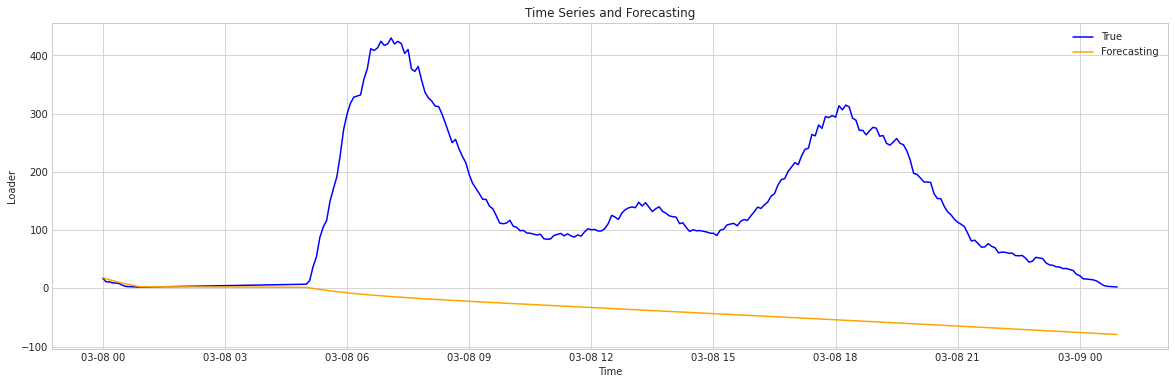

In [23]:
node = nodes[4]
plt.figure(figsize=(20, 6))
plt.plot(df_test.time, df_test[f'carregamento_node_{node}'], label=f'True', color='blue')
plt.plot(df_test.time, df_test[f'y_pred_{node}'], label=f'Forecasting', color='orange')
plt.xlabel('Time')
plt.ylabel('Loader')
plt.title('Time Series and Forecasting')
plt.legend()
plt.show()

In [28]:
node = nodes[0]
node

694

In [36]:
df_test[f"carregamento_node_{node}"].describe()

count   252.0000000000000000
mean    255.6448412698412653
std     176.3055838148754049
min       2.7500000000000000
25%     136.5000000000000000
50%     206.3749999999999716
75%     373.5000000000000000
max     665.9166666666666288
Name: carregamento_node_694, dtype: float64

In [34]:
true = df_test[f"carregamento_node_{node}"]+1
pred = df_test[f"y_pred_{node}"]+1

In [35]:
true.describe()

count   252.0000000000000000
mean    256.6448412698412653
std     176.3055838148754049
min       3.7500000000000000
25%     137.5000000000000000
50%     207.3749999999999716
75%     374.5000000000000000
max     666.9166666666666288
Name: carregamento_node_694, dtype: float64

In [29]:
mean_absolute_percentage_error(true, df_test[f"y_pred_{node}"]+1)

1.6627600390521986

In [31]:
mean_absolute_percentage_error(df_test[f"carregamento_node_{node}"], df_test[f"y_pred_{node}"])

1.7620100158955045

In [32]:
df_test

,time,day,partition,partition_nn,carregamento_node_694,carregamento_node_2772,carregamento_node_1203,carregamento_node_592,carregamento_node_561,y_pred_694,y_pred_2772,y_pred_1203,y_pred_592,y_pred_561
1668,2024-03-08 00:00:00,8,test,test,26.6666666666666679,24.5833333333333286,0.2500000000000000,2.5000000000000000,17.5833333333333321,29.0516741360272199,20.6336298134296570,1.2867803850915061,2.5598856969190038,18.3432863443775780
1669,2024-03-08 00:05:00,8,test,test,24.4166666666666679,24.8333333333333286,0.5000000000000000,2.5000000000000000,11.4166666666666661,24.8656909387216452,13.5002330736817520,0.8358797052574840,2.7462310070068541,16.5644810493690962
1670,2024-03-08 00:10:00,8,test,test,18.0000000000000000,18.0000000000000000,0.5000000000000000,1.5000000000000000,11.1666666666666661,19.3296718260129339,8.2765953486444133,0.3372401196502116,2.8010722865670346,14.8479201754300938
1671,2024-03-08 00:15:00,8,test,test,18.2500000000000000,12.9166666666666661,0.5000000000000000,1.5000000000000000,9.3333333333333339,13.8548664766713987,4.3679471626652155,-0.2447653005561005,2.8489296683298435,13.2219809549728211
1672,2024-03-08 00:20:00,8,test,test,15.4166666666666661,8.6666666666666661,0.5000000000000000,1.5000000000000000,9.2500000000000000,8.7246672197079800,0.7705538193260542,-0.7665216927906037,2.8906925339587892,11.6809642145481156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2024-03-09 00:35:00,9,test,test,9.3333333333333339,5.9166666666666670,0.4166666666666667,1.4166666666666667,5.0000000000000000,-67.6493185378033246,-28.5440108968872757,-5.2849304041169569,3.1768738988501273,-77.9139030857434989
1916,2024-03-09 00:40:00,9,test,test,4.4166666666666670,5.6666666666666670,0.4166666666666667,0.4166666666666667,3.5833333333333330,-67.6493191999109058,-28.4232957911349828,-5.2849304041183292,3.1768738988501273,-78.2244939211628605
1917,2024-03-09 00:45:00,9,test,test,4.0000000000000000,4.2500000000000000,0.4166666666666667,0.6666666666666666,3.0833333333333330,-67.6493198203427966,-28.3019891454801211,-5.2849304041195593,3.1768738988501273,-78.5352481225532415
1918,2024-03-09 00:50:00,9,test,test,3.5000000000000000,4.1666666666666670,0.4166666666666667,0.2500000000000000,2.7500000000000000,-67.6493204017222212,-28.1800909599562672,-5.2849304041206624,3.1768738988501273,-78.8461656905895154


In [38]:
def mean_absolute_percentage_error_np(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [42]:
mapes = []
for nd in nodes:
    y_true = df_test[f'carregamento_node_{nd}']+1
    y_pred = df_test[f'y_pred_{nd}']+1
    mape       = mean_absolute_percentage_error(y_true, y_pred)
    mape_stats = mean_absolute_percentage_error_np(y_true, y_pred)
    print(f"node {nd} - MAPE: {mape} MAPE np: {mape_stats:.2f}")
    mapes.append(mape)

node 694 - MAPE: 1.6627600390521986 MAPE np: 166.28
node 2772 - MAPE: 1.3878227902032796 MAPE np: 138.78
node 1203 - MAPE: 1.2801263199636241 MAPE np: 128.01
node 592 - MAPE: 0.8076143487371511 MAPE np: 80.76
node 561 - MAPE: 1.8343761081578451 MAPE np: 183.44


In [43]:
?mean_absolute_percentage_error

Signature:
mean_absolute_percentage_error(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput='uniform_average',
)
Docstring:
Mean absolute percentage error (MAPE) regression loss.

Note here that the output is not a percentage in the range [0, 100]
and a value of 100 does not mean 100% but 1e2. Furthermore, the output
can be arbitrarily high when `y_true` is small (which is specific to the
metric) or when `abs(y_true - y_pred)` is large (which is common for most
regression metrics). Read more in the
:ref:`User Guide <mean_absolute_percentage_error>`.

.. versionadded:: 0.24

Parameters
----------
y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Ground truth (correct) target values.

y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Estimated target values.

sample_weight : array-like of shape (n_samples,), default=None
    Sample weights.

multioutput : {'raw_values', 'uniform_average'} or array-like
    Defines aggregat

In [52]:
abs(1 - 2.2) / 1

1.2000000000000002